<a href="https://colab.research.google.com/github/soniaeya/NLP_A1_Guide/blob/ynes/Copy_of_assignment1_guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assigment 2: Word2vec and CBOW ⚡


In this assignment, we will guide you through the process of implementing Continous Bag Of Words (CBOW) using PyTorch, providing step-by-step instructions, code snippets, and explanations to aid your understanding. By the end of this assignment, you will have a solid grasp of Word2Vec's mechanics and be equipped to apply this knowledge to a wide range of NLP tasks.

Let's embark on this journey to unlock the power of word embeddings with Word2Vec and PyTorch!

This [guide](https://pytorch.org/tutorials/beginner/basics/intro.html) might come in handy to understand how Pytorch works.

Let's start by installing the needed libraries

In [1]:
!pip install gensim

In [2]:
import torch
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In this assigment we will use the dataset *text8*. This dataset is composed of textual content extracted from Wikipedia articles which hopefully will lead to good embeddings when input in CBOW.

In [3]:
import gensim.downloader as api

dataset = list(api.load("text8"))[0:100] #We trim the dataset to make training as long. Feel free to change this based on your resources

[==================================================] 100.0% 31.6/31.6MB downloaded


Let's have a look at a datapoint.

In [4]:
(" ").join(dataset[0])

'anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic instituti

Normally we would need to do some data preprocessing in order to clean our dataset but lucky for you the professor chose a pretty and clean dataset so you don't have to 😉

Let's start to get more on topic. If you remember, Word2Vec has a specific way of generating each vector.
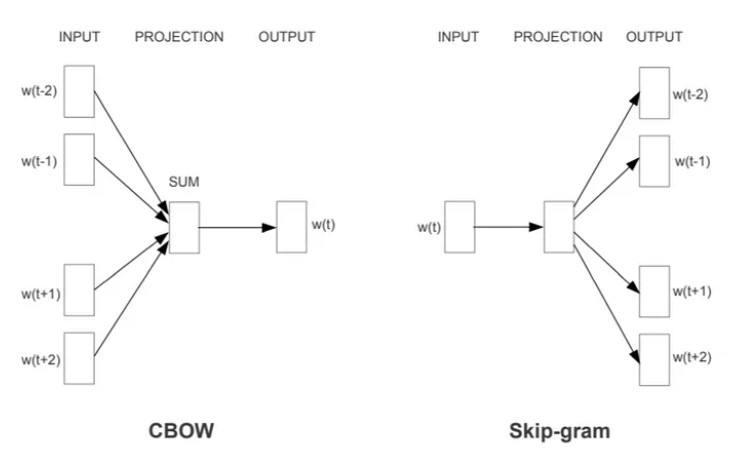

The embedding is based on the surrounding words (before and after) taken as context. In the case of CBOW, we input the surrounding words to our neural network and expect that it predicts the middle word. Let's format our dataset to meet the needs of the neural network.


Since our neural networks can't understand strings we have to turn these strings into integers. In this case, we can use the one hot encodings to represent the words, so we will need the mapping: word -> one-hot-encoding

In [5]:
import pandas as pd
import torch
import torch.nn.functional as F

def create_word_to_index(vocab_list):
  """ Method that creates dictionary that maps words to an index.
  Arguments
  ---------
  vocab_list : list(String)
    List of words in the vocabulary
  Returns
  -------
  word_to_index : Dictionary
    Dictionary mapping words to index with format {word:index}
  """
  word_to_index = {}

  for i,word in enumerate(vocab_list):
    # unique int ID to each word
    word_to_index[word] = i
  return word_to_index

vocab_list = list(set(word for sentence in dataset for word in sentence))
word_to_index = create_word_to_index(vocab_list)

In [6]:
def generate_dataset(dataset, window_size,word_to_index):
  """ Method to generate training dataset for CBOW.
  Arguments
  ---------
  data : String
     Training dataset
  window_size : int
     Size of the context window
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  surroundings : N x W Tensor
      Tensor with index of surrounding words, with N being the number of samples and W being the window size
  targets : Tensor
      Tensor with index of target word
  """
  # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
  surroundings= []
  targets = []

  for data in dataset:
    for i in range(window_size,len(data)-window_size): # i = idx of target word
    # j iterates through the window range, but skips i, the idx of the target word
    # data[j] are the words surrounding the target word
    # word_to_index[data[j]] are the indexes of the surrounding words
    # surrounding is a dictionary of the surrounding word indexes

      surrounding = [word_to_index[data[j]] for j in range (i - window_size, i + window_size + 1) if j != i] #get indexes of surrounding words in a list
      surrounding = torch.tensor(surrounding)
      target = word_to_index[data[i]] #get index of target word
      surroundings.append(surrounding)
      targets.append(target)

  surroundings = torch.stack(surroundings)
  targets = torch.tensor(targets)
  return surroundings, targets


WINDOW_SIZE = 2
surroundings, targets = generate_dataset(dataset,WINDOW_SIZE,word_to_index)
generate_dataset(dataset,WINDOW_SIZE,word_to_index)




(tensor([[ 8014,  3678, 26966, 22841],
         [ 3678, 13766, 22841, 27622],
         [13766, 26966, 27622, 50196],
         ...,
         [52144, 45217,  3523, 13766],
         [45217, 44251, 13766, 12028],
         [44251,  3523, 12028, 22285]]),
 tensor([13766, 26966, 22841,  ..., 44251,  3523, 13766]))

With our dataset ready we can finally create our Neural Network. The idea is to replicate what Mikolov did in 2013 (see slides of Word2Vec).

In [7]:
import torch.nn as nn
class CBOW(nn.Module):
  def __init__(self, vocab_size, embed_dim=300):
    """ Class to define the CBOW model
    Attributes
    ---------
    device : device
      Device where the model will be trained (gpu preferably)
    vocab_size : int
      Size of the vocabulary
    embed_dim : int
      Size of the embedding layer
    hidden_dim : int
      Size of the hidden layer

    """
    super().__init__()

    self.device = device
    self.vocab_size = vocab_size # input size
    self.embed_dim = embed_dim
    self.hidden_dim = 128 # Define hidden_dim before using it

    # nn.Embedding will turn word indices into vectors
    self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_dim)
    # 2 linear layers
    self.linear_in = nn.Linear(self.embed_dim, self.hidden_dim, bias=False)# Linear layer that encodes one-hot-encoding to embedding dimension. Remember Mikolov's implementation had NO BIAS
    self.linear_out = nn.Linear(self.hidden_dim, self.vocab_size, bias=False)# Linear layer that decodes from embedding dimension to vocab dimension. Remember Mikolov's implementation had NO BIAS

  def forward(self, x):
    emb = self.embedding(x) #pass input (indices of surrounding words) through embedding layer
    average = torch.mean(emb, dim = 1) #average embeddings
    out = self.linear_in(average)  #pass through linear layer
    out = self.linear_out(out) #pass through output linear layer

    return out

We will need an important function that creates one hot encoding vectors based on our surrounding word's indexes

In [8]:
def one_hot_from_surroundings(surroundings,window_size, vocab_size):
  """ Method to create one hot encodings for the surrounding words.
  Arguments
  ---------
  surroundings : N x (Wx2) Tensor
     Tensor with index of surrounding words, with N being the number of samples and W being the window size
  vocab_size : int
     Size of the vocabulary
  Returns
  -------
  one_hot_surroundings : N x (Wx2) x V Tensor
      Tensor with one hot encodings of surrounding words, with N being the number of samples, W being the window size and V being the vocabulary size
  """
  one_hot_surr = torch.nn.functional.one_hot(surroundings, num_classes=vocab_size)
  return one_hot_surr


In [9]:
#Check if your previous function is correct
index= [[2,3,7,8],[0,1,9,5]]
index_tensor = torch.tensor(index).to(device)
answer = torch.tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]], device=device)

prediction = one_hot_from_surroundings(index_tensor,2,10)
assert prediction.shape == torch.Size([2, 4, 10]), "Make sure the result has shape NUM_EXAMPLES X WINDOW_SIZE*2 X VOCAB_SIZE"
assert torch.equal(prediction,answer), "Wrong implementation of one_hot_from_surroundings method"
print("Good Job!")

Good Job!


Now we are finally ready to train

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
#creation of dataloader for training
full_dataset = list(zip(surroundings,targets))
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_dataloader=DataLoader(train_dataset,batch_size=128,shuffle=True) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)
val_dataloader=DataLoader(val_dataset,batch_size=128,shuffle=False) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)

In [11]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG

EMB_DIM = 300
CBOW_MODEL = CBOW(len(word_to_index), embed_dim= EMB_DIM).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CBOW_MODEL.parameters(), lr=0.001)
EPOCHS = 5

#BE PATIENT: This code can take up to 1 hours for a batch size of 64 and 5 epochs

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
  total_loss = 0
  i=0

  for surr, tar in tqdm(train_dataloader,"Training"):

      surr, tar = surr.to(device), tar.to(device)
      one_hot_surr = one_hot_from_surroundings(surr,WINDOW_SIZE, len(word_to_index)) # Remove this line

      optimizer.zero_grad()
      log_probs = model(surr) # Pass indices through model

      loss= loss_function(log_probs,tar)
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

  return total_loss/len(train_dataloader)

def evaluate_model(model, val_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
      for surr, tar in tqdm(val_loader, "Validation"):
          surr, tar = surr.to(device), tar.to(device)

          one_hot_surr = one_hot_from_surroundings(surr,WINDOW_SIZE, len(word_to_index)) # Remove this line

          log_probs = model(surr) # Pass indices through model

          loss= loss_function(log_probs,tar)
          total_loss += loss.item()
  return total_loss/len(val_loader)


for epoch in range(EPOCHS):
  train_loss = train_model(CBOW_MODEL, train_dataloader, val_dataloader, epochs=1, lr=0.001)
  val_loss = evaluate_model(CBOW_MODEL, val_dataloader)
  print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#   cbow_train_losses.append(train_loss)
#   cbow_valid_losses.append(val_loss)

# # to plot the losses - will confirm cbow is learning
# import matplotlib.pyplot as plt

# plt.figure()
# plt.plot(range(1, len(cbow_train_losses)+1), cbow_train_losses, label="Train CE Loss")
# plt.plot(range(1, len(cbow_valid_losses)+1), cbow_valid_losses, label="Val CE Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Cross-Entropy Loss")
# plt.title("IMDB Training and Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

Validation: 100%|██████████| 1562/1562 [00:01<00:00, 1107.98it/s]


Epoch 1, Train Loss: 7.1294, Val Loss: 6.7265


Validation: 100%|██████████| 1562/1562 [00:01<00:00, 1134.38it/s]


Epoch 2, Train Loss: 6.1842, Val Loss: 6.5663


Validation: 100%|██████████| 1562/1562 [00:01<00:00, 1112.60it/s]


Epoch 3, Train Loss: 5.6036, Val Loss: 6.5916


Validation: 100%|██████████| 1562/1562 [00:01<00:00, 1142.94it/s]


Epoch 4, Train Loss: 5.1388, Val Loss: 6.6590


Validation: 100%|██████████| 1562/1562 [00:01<00:00, 1132.00it/s]

Epoch 5, Train Loss: 4.7672, Val Loss: 6.7982


## Let's test it!

Now that we hopefully have good embeddings we can put them to the test. Let's start by creating some useful functions.

In [12]:
def create_word_to_embedding (vocab_list, model,word_to_index):
  """ Method to get create dictionary that maps a word to it's embedding vector.
  Arguments
  ---------
  word : String
     Word given
  model : NN.module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  word_embedding : Tensor
      Embedding vector for the given word
    """

  # Get the weights of the embedding layer (remove .detach() and .cpu())
  embedding_weights = model.embedding.weight
  word_to_embedding = {}

  for word in vocab_list:
    # Get word index
    index=  word_to_index[word]
    # Extract the embedding vector for the given word index. This is done by getting the row of the index specified
    word_embedding = embedding_weights[index, :]
    word_to_embedding[word] = word_embedding

  return word_to_embedding

word_to_embedding = create_word_to_embedding(vocab_list,CBOW_MODEL,word_to_index)
if 'study' in word_to_embedding:
  print("Embedding of word 'study'", word_to_embedding['study'])
else:
  print("Word 'study' not found in the vocabulary.")

Embedding of word 'study' tensor([-1.0166e+00,  5.8082e-02, -9.7099e-02, -8.4048e-01, -4.1306e-01,
         3.8183e-01, -1.2268e+00, -5.3631e-01,  8.8635e-01,  9.7431e-02,
        -1.1141e+00, -1.5101e+00,  6.0213e-01, -6.6031e-01, -3.1275e-01,
         3.5680e-02, -9.8038e-01, -1.8552e+00,  4.2226e-01, -1.7475e-01,
         1.1001e+00,  2.9798e+00, -1.0320e+00,  1.6969e+00,  4.2807e-01,
        -7.6953e-01, -1.0341e+00, -7.9314e-01,  1.6796e+00, -1.5642e-01,
         8.6233e-03, -9.4220e-01, -2.1106e+00, -8.6332e-02, -6.1098e-01,
         1.6735e+00,  3.5765e-01,  6.6870e-01,  1.6444e-01,  8.3688e-01,
        -2.2407e-01, -4.4939e-01,  1.6040e+00,  8.5714e-01,  8.5923e-01,
         8.3674e-01,  1.5081e+00, -8.3847e-01,  7.3768e-01, -8.8660e-01,
        -1.0510e+00, -3.8992e-01, -2.5291e-01,  4.3176e-02, -5.1146e-03,
        -1.3623e-01,  1.0286e+00, -2.0540e+00,  8.0309e-01,  8.6290e-03,
        -2.1397e+00,  1.3835e+00,  1.4758e+00,  1.1638e+00, -2.2477e+00,
         1.0130e+00, -2.0

We will test how good our word2vec model is by testing the embeddings on the downstream task of sentiment analysis of movies 🎥

Let's first import and download this dataset.


In [13]:
from keras.datasets import imdb

def decode_review(word_index, review):
  decoded_review = " ".join([reverse_word_index.get(i - 3, "") for i in review])
  return decoded_review

(train_data, train_labels), (test_data, test_labels)= imdb.load_data(num_words=10000)
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

# We will trim the dataset to not make training to long, feel free to change this based on your resources
train_data = train_data[:10000]
train_labels = train_labels[:10000]
test_data = test_data[:2000]
test_labels = test_labels[:2000]

#Decode data
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
train_data = [decode_review(reverse_word_index,x) for x in train_data]
test_data = [decode_review(reverse_word_index,x) for x in test_data]

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


Now we can create a simple Sentiment classifier that will use our embeddings from our CBOW model. The model input will be an average of the word embeddings of the review and the output will be a binary: positive🙂 or negative😞.

Let's start by creating our Dataloaders

In [14]:
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]


def get_review_embedding(review):
  """ Method to get the embedding vector for a given review.
  Arguments
  ---------
  review : String
     Review given
  model : NN.module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  review_embedding : Tensor
      Embedding vector for the given review
  """
  # TODO write a function that gets sentence embedding by averaging the embeddings of the words in the review (only take into account words in vocab)
  words = review.split()
  sum_embeddings = torch.zeros(list(word_to_embedding.values())[0].shape, device=device, requires_grad=True) # Explicitly set requires_grad=True
  count = 0
  for word in words:
    if word in word_to_embedding:
      # Ensure embedding is on the correct device and add to sum_embeddings
      # Use .clone() to avoid modifying the original tensor in word_to_embedding
      sum_embeddings = sum_embeddings + word_to_embedding[word].to(device)
      count += 1
  if count > 0:
    review_embedding = sum_embeddings / count
  else:
    # Non known word (zero vector)-Return a zero vector with requires_grad=True
    review_embedding = torch.zeros(list(word_to_embedding.values())[0].shape, device=device, requires_grad=True)

  return review_embedding


def create_dataloader_imdb(train_data, train_labels, test_data, test_labels, batch_size= 64):
  """ Method to create dataloaders for the IMDB dataset
  Arguments
  ---------
  train_data : List
     List of reviews for training
     train_labels : List
     List of labels for training
  test_data : List
     List of reviews for testing
  test_labels : List
     List of labels for testing
  Returns
  -------

  """
  train_dataset = ReviewDataset(train_data, train_labels)
  test_dataset = ReviewDataset(test_data, test_labels)


  train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
  test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
  return train_dataloader, test_dataloader


train_dataloader_imd , test_dataloader_imd = create_dataloader_imdb(train_data, train_labels, test_data, test_labels)

Let's create a very simple MLP for this classification problem

In [15]:
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
      # TODO complete forward
      x = self.fc1(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      return x


Now the fun part, time to train

In [16]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG
SENT_MODEL = SentimentClassifier(embedding_dim=EMB_DIM).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SENT_MODEL.parameters(), lr=0.001)
EPOCHS = 5

#BE PATIENT: This code can take up to 1 hours for a batch size of 64 and 5 epochs

def train_model(model, train_loader):
  model.train()
  total_loss = 0
  for reviews, y in tqdm(train_loader,"Training"):
    # Calculate review embeddings dynamically with gradient tracking
    X = torch.stack([get_review_embedding(review) for review in reviews]).to(device)
    y = y.to(device) # Move labels to device

    optimizer.zero_grad() # Zero the gradients
    out = model(X) # Forward pass
    loss = loss_function(out, y) # Calculate the loss
    loss.backward() # Backpropagate the error
    optimizer.step() # Update the weights

    total_loss += loss.item()

  return total_loss/len(train_loader)

def evaluate_model(model, val_loader):
  model.eval()
  correct, total = 0, 0
  all_predictions = []
  all_labels = []
  with torch.no_grad():
    for reviews, y in tqdm(val_loader,"Validation"):
        # Calculate review embeddings dynamically (without gradient tracking for evaluation)
        X = torch.stack([get_review_embedding(review) for review in reviews]).to(device)
        y = y.to(device) # Move labels to device

        out = model(X) # Forward pass
        preds = torch.softmax(out, dim=1)  # Pass through softmax layer
        preds = torch.argmax(preds, dim=1)  #Get prediction by doing argmax
        correct += (preds == y).sum().item() # Check how many are correct
        all_predictions.extend(preds.cpu().numpy()) # Save predictions
        all_labels.extend(y.cpu().numpy()) # Save labels
        total += y.size(0)
  acc = correct / total
  return acc, all_predictions, all_labels



for epoch in range(EPOCHS):
  train_loss = train_model(SENT_MODEL, train_dataloader_imd)
  validation_accuracy , predictions, labels= evaluate_model(SENT_MODEL, test_dataloader_imd)
  print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

#   cbow_train_losses.append(train_loss)
#   cbow_valid_losses.append(validation_accuracy)

# # to plot the losses
# import matplotlib.pyplot as plt

# plt.figure()
# plt.plot(range(1, len(cbow_train_losses)+1), cbow_train_losses, label="Train CE Loss")
# plt.plot(range(1, len(cbow_valid_losses)+1), cbow_valid_losses, label="Val CE Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Cross-Entropy Loss")
# plt.title("IMDB Training and Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

Validation: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s]


Epoch 1, Train Loss: 0.6221, Validation Accuracy: 0.7145


Validation: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


Epoch 2, Train Loss: 0.5329, Validation Accuracy: 0.7115


Validation: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


Epoch 3, Train Loss: 0.5148, Validation Accuracy: 0.7595


Validation: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


Epoch 4, Train Loss: 0.4980, Validation Accuracy: 0.7655


Validation: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]

Epoch 5, Train Loss: 0.4908, Validation Accuracy: 0.7645


Calculate precision, recall and F-measure of our Sentiment Analysis model. Also plot Confusion Matrix

Precision: 0.7679
Recall: 0.7645
F1 Measure: 0.7645


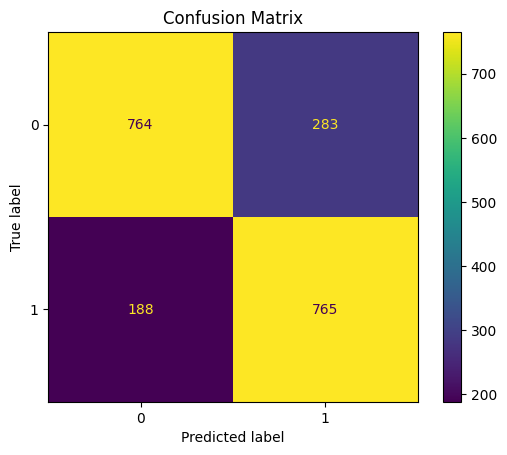


Classification report (per class):
              precision    recall  f1-score   support

    negative       0.80      0.73      0.76      1047
    positive       0.73      0.80      0.76       953

    accuracy                           0.76      2000
   macro avg       0.77      0.77      0.76      2000
weighted avg       0.77      0.76      0.76      2000



In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


# ########## TO SAVE CHECKPOINTS to change later ########################

import os
out_dir = 'outputs'
os.makedirs(out_dir, exist_ok=True)

import json
def save_json(ojb,path):
  with open(path,'w') as f:
    json.dump(ojb,f,indent=2)
# ##################################################




# You have already a np.array of labels and predictions

#TODO calculate precision, recall and F1 measure and print Confusion Matrix

# Calculate precision, recall, and F1 measure
precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Measure: {f1:.4f}")

# Calculate and plot the confusion matrix
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
print("\nClassification report (per class):")
print(classification_report(labels, predictions, target_names=["negative", "positive"]))

# Let's Experiment! 🤓

Pick 3 of the following experiments and develop a solution **in this same notebook**. Take advange of the notebook structure to give a clear structure of experiment -> conclusions

1. Compare with another pretrained word2vec model
2. Experiment with a different sentiment analysis dataset (might require change in architecture of sentiment analyser)
3. Train your CBOW model on a different train set (might require data preprocessing)
4. Play with hyperparameters (window size, embedding dimension)


# 🧮 Experiment 1 - Different Sentiment Analysis Data set

In this section, we will load a different sentiment analysis dataset, and we will evaluate whether we are getting a similar performance as the one gotten with the IMDB dataset.

Here we will not be using a binary sentiment anaylis. The dataset used is from Twitter (X), tweets will labels as either positive, negative, or neutral.
We will see if the model is able to perform similarly as with the IMDB dataset.


This dataset has 3 classes: negative, neutral, positive


Training (TweetEvals):   0%|          | 0/235 [00:00<?, ?it/s]/tmp/ipython-input-1658703854.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y= torch.tensor(labels_ints, dtype=torch.long , device=device)
Evaluating (TweetEvals): 100%|██████████| 32/32 [00:01<00:00, 17.29it/s]


[TweetEval] Epoch 1/5, Train Loss: 0.9761, Validation Accuracy: 0.5230


Evaluating (TweetEvals): 100%|██████████| 32/32 [00:01<00:00, 17.27it/s]


[TweetEval] Epoch 2/5, Train Loss: 0.9284, Validation Accuracy: 0.5195


Evaluating (TweetEvals): 100%|██████████| 32/32 [00:01<00:00, 17.27it/s]


[TweetEval] Epoch 3/5, Train Loss: 0.9075, Validation Accuracy: 0.5245


Evaluating (TweetEvals): 100%|██████████| 32/32 [00:01<00:00, 17.44it/s]


[TweetEval] Epoch 4/5, Train Loss: 0.8860, Validation Accuracy: 0.5205


Evaluating (TweetEvals): 100%|██████████| 32/32 [00:01<00:00, 17.31it/s]


[TweetEval] Epoch 5/5, Train Loss: 0.8599, Validation Accuracy: 0.5350


Evaluating (TweetEvals): 100%|██████████| 32/32 [00:01<00:00, 17.71it/s]


Test Accuracy of Experiement #1: 0.4340
Macro Precision: 0.4255
Macro Recall: 0.4189
Macro F1: 0.3738

Weighted Precision: 0.4537
Weighted Recall: 0.4340
Weighted F1: 0.3969


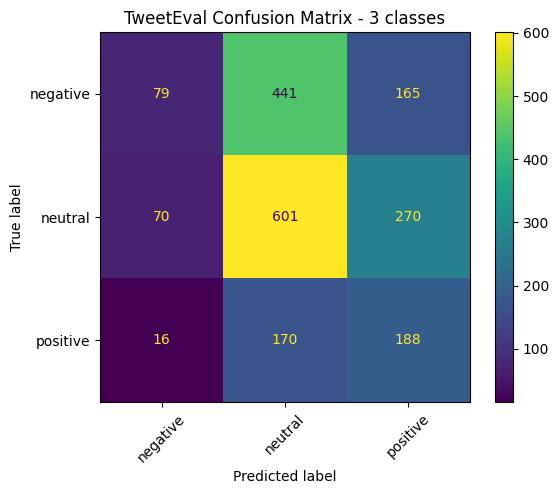

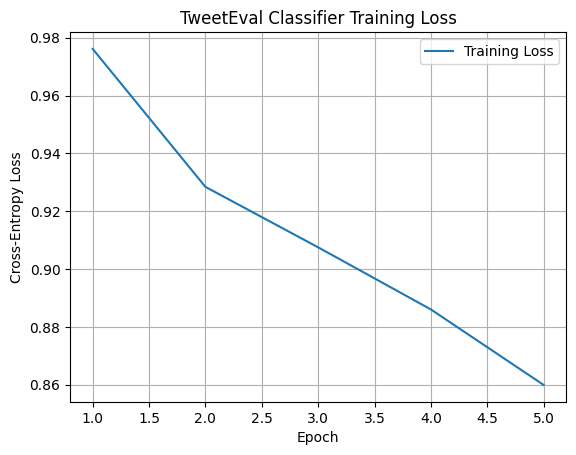

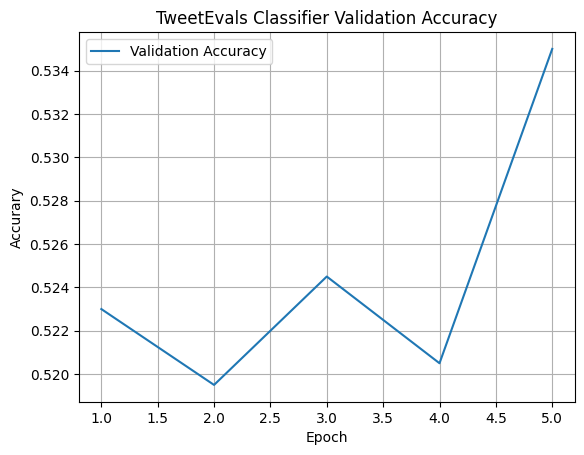

In [21]:
!pip install -q datasets
from datasets import load_dataset

tweets_dataset = load_dataset("tweet_eval", "sentiment")
# 0 = negative
# 1 = neutral
# 2 = positive
label_names_exp = tweets_dataset["train"].features["label"].names
num_classes_exp = len(label_names_exp)
print(f"This dataset has {num_classes_exp} classes: {', '.join(label_names_exp)}")

# for speed we won't be processing whe whole file
import random
random.seed(0)
tweets_dataset["train"] = tweets_dataset["train"].shuffle(seed=0).select(range(15000))
tweets_dataset["validation"] = tweets_dataset["validation"].shuffle(seed=0).select(range(2000))
tweets_dataset["test"] = tweets_dataset["test"].shuffle(seed=0).select(range(2000))

# Processing the DS - lower case for consistency
train_texts_exp = [t.lower() for t in tweets_dataset["train"]["text"]]
test_texts_exp = [t.lower() for t in tweets_dataset["test"]["text"]]
validation_texts_exp = [t.lower() for t in tweets_dataset["validation"]["text"]]

train_labels_exp = tweets_dataset["train"]["label"]
test_labels_exp = tweets_dataset["test"]["label"]
validation_labels_exp = tweets_dataset["validation"]["label"]





def create_dataloader_tweet(train_data, train_labels, test_data, test_labels, batch_size= 64):
  """ Method to create dataloaders for the IMDB dataset
  Arguments
  ---------
  train_data : List
     List of reviews for training
     train_labels : List
     List of labels for training
  test_data : List
     List of reviews for testing
  test_labels : List
     List of labels for testing
  Returns
  -------

  """
  train_dataset = ReviewDataset(train_data, train_labels)
  test_dataset = ReviewDataset(test_data, test_labels)


  train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
  test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
  return train_dataloader, test_dataloader


# data loading
train_loader_exp , val_loader_exp = create_dataloader_tweet(train_texts_exp, train_labels_exp, validation_texts_exp, validation_labels_exp, batch_size=64)
_, test_loader_exp = create_dataloader_tweet(validation_texts_exp,validation_labels_exp,test_texts_exp, test_labels_exp, batch_size=64)


# creating model for 3 labels sentiment analysis
MODEL_TWEETS  = SentimentClassifier(embedding_dim=EMB_DIM, hidden_dim=128, num_classes = num_classes_exp).to(device)
loss_function_exp = nn.CrossEntropyLoss()
optimizer_exp = torch.optim.Adam(MODEL_TWEETS.parameters(), lr=0.001)

# put new names to the imports so no confusion :)
from tqdm import tqdm
import numpy as np
import torch

def train_epoch_exp(model, data_loader, optimizer, loss_func):
  # train one epoch over TweetEvals using CBOW embeddings
  model.train()
  total_loss = 0.0

  for reviews, labels_ints in tqdm(data_loader, desc ="Training (TweetEvals)"):
    y= torch.tensor(labels_ints, dtype=torch.long , device=device)
    # builts [B, emd_dim] by avh word emdeddings per review
    x = torch.stack([get_review_embedding(review) for review in reviews]).to(device)

    optimizer.zero_grad()
    logits = model(x)
    loss = loss_func(logits, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(data_loader)

@torch.no_grad()
def evaluate_model_exp(model, data_loader):
  # get overall performance of the model, accuranry, predictions, labels
  model.eval()
  correct, total = 0, 0
  all_predictions = []
  all_labels = []
  all_proba = []

  for reviews, labels_ints in tqdm(data_loader, desc ="Evaluating (TweetEvals)"):
    y= torch.as_tensor(labels_ints, dtype=torch.long , device=device)
    x = torch.stack([get_review_embedding(review) for review in reviews]).to(device)

    logits = model(x)
    proba = torch.softmax(logits, dim=1)
    preds = torch.argmax(proba, dim=1)

    correct += (preds == y).sum().item()
    total += y.size(0)

    all_predictions.extend(preds.cpu().tolist())
    all_labels.extend(y.cpu().tolist())
    all_proba.extend(proba.cpu().tolist())

  acc = correct / total
  return acc, np.array(all_predictions), np.array(all_labels), np.array(all_proba)

EPOCHS_EXP = 5
classifer_train_losses_exp = []
classifer_accuracy_losses_exp = []

for epoch in range(EPOCHS_EXP):
  train_loss_exp = train_epoch_exp(MODEL_TWEETS, train_loader_exp, optimizer_exp, loss_function_exp)
  validation_accuracy_exp, _, _, _ = evaluate_model_exp(MODEL_TWEETS, val_loader_exp)
  print(f"[TweetEval] Epoch {epoch+1}/{EPOCHS_EXP}, Train Loss: {train_loss_exp:.4f}, Validation Accuracy: {validation_accuracy_exp:.4f}")
  classifer_train_losses_exp.append(train_loss_exp)
  classifer_accuracy_losses_exp.append(validation_accuracy_exp)

# Test Evals and Visualization of the overall performance
test_accuracy_exp, predictions_exp, labels_exp, proba_exp = evaluate_model_exp(MODEL_TWEETS, test_loader_exp)
print(f"Test Accuracy of Experiement #1: {test_accuracy_exp:.4f}")

#calculating per: class/recall F1 and confusion matrix
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_fscore_support, precision_score, recall_score, f1_score
)

import matplotlib.pyplot as plt
import numpy as np

# overall metrics macro
precision_macro_exp = precision_score(labels_exp, predictions_exp, average='macro', zero_division=0)
recall_macro_exp = recall_score(labels_exp, predictions_exp, average='macro', zero_division=0)
f1_macro_exp = f1_score(labels_exp, predictions_exp, average='macro', zero_division=0)

# overall metrics weighted
precision_weighted_exp = precision_score(labels_exp, predictions_exp, average='weighted', zero_division=0)
recall_weighted_exp = recall_score(labels_exp, predictions_exp, average='weighted', zero_division=0)
f1_weighted_exp = f1_score(labels_exp, predictions_exp, average='weighted', zero_division=0)

print(f"Macro Precision: {precision_macro_exp:.4f}")
print(f"Macro Recall: {recall_macro_exp:.4f}")
print(f"Macro F1: {f1_macro_exp:.4f}")

print(f"\nWeighted Precision: {precision_weighted_exp:.4f}")
print(f"Weighted Recall: {recall_weighted_exp:.4f}")
print(f"Weighted F1: {f1_weighted_exp:.4f}")

# Calculate and plot the confusion matrix
cm_exp = confusion_matrix(labels_exp, predictions_exp, labels=list(range(num_classes_exp)))
disp_exp = ConfusionMatrixDisplay(confusion_matrix=cm_exp, display_labels=label_names_exp)
disp_exp.plot(xticks_rotation=45)
plt.title('TweetEval Confusion Matrix - 3 classes')
plt.grid(False)
plt.show()

# learning curve with new DS
plt.figure()
plt.plot(range(1,len(classifer_train_losses_exp)+1), classifer_train_losses_exp, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("TweetEval Classifier Training Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1,len(classifer_accuracy_losses_exp)+1), classifer_accuracy_losses_exp, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accurary")
plt.title("TweetEvals Classifier Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()





As can be seen above, the classifier trained with the dataset of tweets is performing more poorly than the one trained with the IMDB dataset.

Compared to the IMDB

| Macro Precision (Tweet) | Macro Recall (Tweet) | Macro F1 (Tweet) |
| --- | --- | --- |
| 0.4255 | 0.4189 | 0.3738 |
<br><br>
  




| Weighted Precision (Tweet) | Weighted Recall (Tweet) | Weighted F1 (Tweet) |
| --- | --- | --- |
| 0.4537 | 0.4340 | 0.3969 |




# 🧮 Experiment 2 - Playing with hyperparameters! 🤓

In this section, we will be **changing the hyperparameters** used to train the model, we will then be comparing the results obtained above with the initial set up!


